In [72]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
src = cv2.imread('lena.jpg',0) # 导入图像

In [74]:
src = cv2.resize(src, (64, 64)) # 将图像大小变为64*64
max_num = src.max() #提取图像中最大像素值
max_num

230

In [82]:
#定义一个高斯核生成函数，输入尺寸和sigma
def Gaussian_kernal(kernel_size, sigma):
    m = int(kernel_size // 2)
    kernel = np.zeros((kernel_size, kernel_size), dtype=np.float64)
    s = 2 * sigma * sigma
    for i in range(kernel_size):
        for j in range(kernel_size):
            x = i - m
            y = j - m
            kernel[i,j] = np.exp(-(x * x + y * y) / s) / (np.pi * s);
    return kernel        

In [89]:
filter_x = np.array([[-1,0,1],[-1,0,1],[-1,0,1]]) #x方向差分滤波器
filter_y = np.array([[-1,-1,-1],[0,0,0],[1,1,1]]) #y方向查分滤波器

In [248]:
imgs = np.zeros((4,64,64))
grad = np.zeros((4,3,64,64))
grad_dir = np.zeros_like(grad)
for i in range(4):
    # 此循环生成3张sigma的高斯噪点图像，和计算包括原图的4张图像的梯度以及方向，
    #选取3个不同sigam的查分高斯滤波，共计4张图像，4 * 3 个梯度图以及 4 * 3 个梯度方向图 
    img = src.copy()
    img = np.array(img, dtype=np.float64)
    if i>0:
        gauss_noisy = np.random.normal(loc=0, scale= max_num * (i+1) * 5.0 / 256, size=(64, 64))  
        #生成基于图像最大亮度的高斯噪点，迭代4次，sigma从 max_num * 5.0 / 256 依次递增一倍    
        img += gauss_noisy # 加入高斯噪点
        img[img > 255.0] = 255.0
        img[img < 0.0] = 0.0 #防止像素值越界
    imgs[i] = img.copy()
    for j in range(3):
        myGaussFilterx = cv2.filter2D(Gaussian_kernal(7, 0.05 + j), -1, filter_x) #对高斯函数差分
        myGaussFiltery = cv2.filter2D(Gaussian_kernal(7, 0.05 + j), -1, filter_y) 
        gradx = cv2.filter2D(img, -1, myGaussFilterx) # 将图像与差分高斯滤波器做卷积
        grady = cv2.filter2D(img, -1, myGaussFiltery)
        gradx[gradx==0] = 1e-5 #防止分母为0
        grad_dir[i,j] = np.arctan(grady/gradx) * 180 / np.pi + 90 #计算梯度方向
        grad[i,j] = np.sqrt(gradx ** 2 + grady ** 2)   #计算梯度幅值

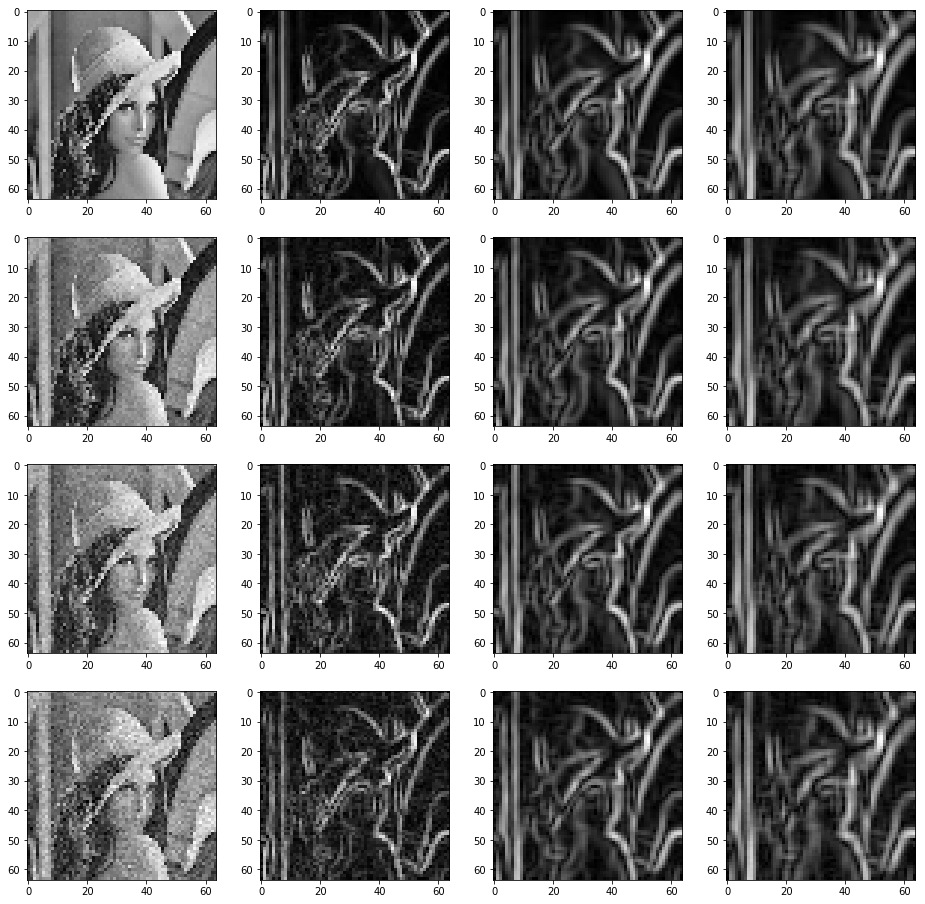

In [249]:
#噪点图与梯度图展示
plt.figure(figsize=(16,16))
flag = 1
for i in range(4):
    plt.subplot(4, 4, flag)
    flag+=1
    plt.imshow(imgs[i], cmap=plt.cm.gray)
    for j in range(3):
        plt.subplot(4, 4, flag)
        flag+=1
        plt.imshow(grad[i,j], cmap=plt.cm.gray)

In [285]:
grad_dir_hist = np.zeros((4,3,9))
for i in range(4):
    #此循环用于生成梯度方向直方图
    for j in range(3):
        for b in range(9):
            brange = b * 20 + 20
            gvalue = grad[i,j][np.logical_and(grad_dir[i,j] >= brange-20 ,grad_dir[i,j] < brange)]
            #提取在每个bin里的梯度值
            gdir = grad_dir[i,j][np.logical_and(grad_dir[i,j] >= brange-20 ,grad_dir[i,j] < brange)]
            #提取在每个bin里梯度方向
            grad_dir_hist[i,j,b] += (gvalue * (gdir - (brange - 20)) / 20).sum()
            #线性分割梯度值
            if b<=7:
                grad_dir_hist[i,j,b+1] += (gvalue * (brange - gdir) / 20).sum()
            else:
                grad_dir_hist[i,j,0] += (gvalue * (brange - gdir) / 20).sum()
                #大于160方向的一部分梯度值归于0方向上
        

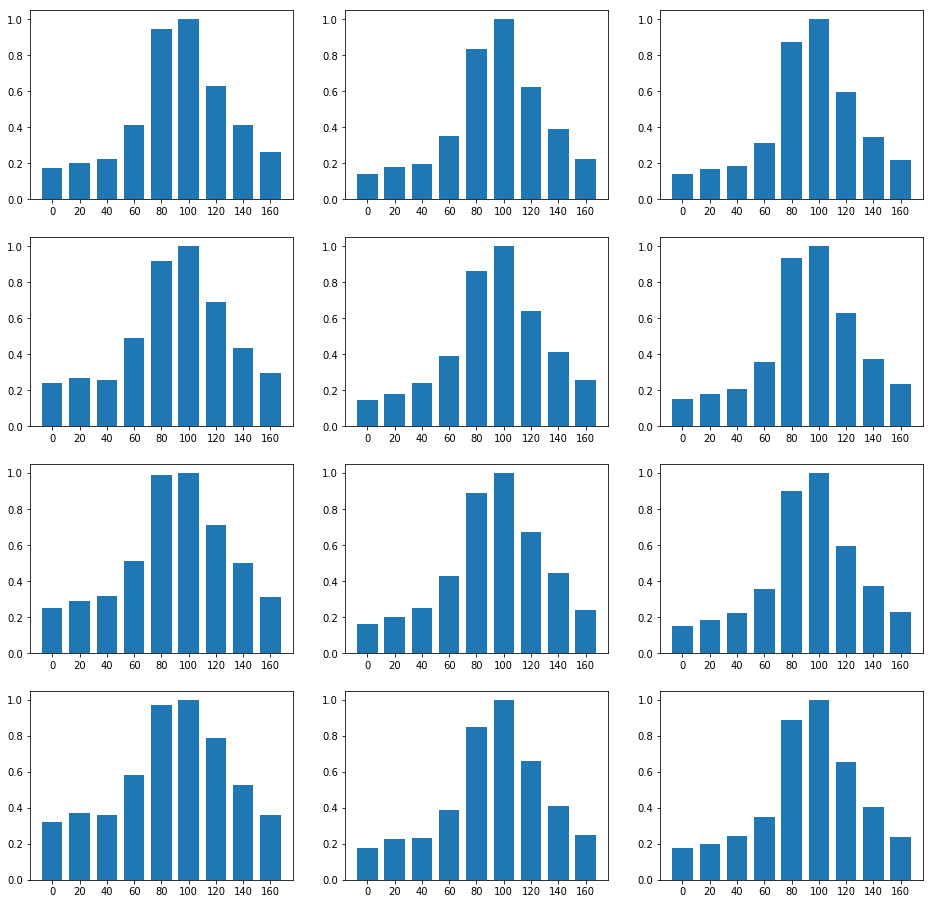

In [311]:
#展示梯度方向直方图
plt.figure(figsize=(16,16))
x = range(0, 180, 20)
flag = 1
for i in range(4):
    for j in range(3):
        plt.subplot(4, 3, flag)
        flag+=1
        plt.xticks(x)
        plt.bar(x, grad_dir_hist[i,j]/grad_dir_hist[i,j].max(),width=15);
